ECG Processing Notebook
--------------------------

This notebook was created 2019-08-27 to look at the initial data collected for the CIMVHR study.

> Using machine learning to investigate sympathetic activation of the autonomic nervous system (SAANS) during the treatment of mild traumatic brain injury, chronic pain, and post-traumatic stress disorder.

This Jupyter Notebook loads ECG data and processes it using the modified Pan-Tompkins QRS detector in `stress/panTompkins.py`.

Download all ECG files from the server to an `ECG/` directory. The list of files that have been considered is shown in `files`. Add or modify files to this list, as required. Select which file to load from `files` by setting `FILE_INDEX`.

We flip certain ECG signals that were inverted after visual inspection.

In [1]:
%load_ext autoreload
%autoreload 2
import stress
import stress.pan_tompkins
import math
import numpy as np
from matplotlib import pyplot as plt 

FILE_INDEX = 3

# load ECG data
files = (
         '2019_06_07-11_18_26_ECG.csv.gz',  #  [0]
         '2019_06_10-10_46_26_ECG.csv.gz',  #  [1]
         '2019_06_14-11_08_30_ECG.csv.gz',  #  [2]
         '2018_12_05-10_35_00_ECG.csv.gz',  #  [3]
         '2019_02_15-12_09_23_ECG.csv.gz',  #  [4] low quality ECG
         '2019_04_05-09_33_16_ECG.csv.gz',  #  [5] 50% usable data... SQI masks data correctly
         '2019_03_29-08_56_55_ECG.csv.gz',  #  [6] (was failing)
         '2019_04_09-11_04_37_ECG.csv.gz',  #  [7] (was failing); works now
)
filename = 'ECG/' + files[FILE_INDEX]
print('loading '+filename+'...')
ecg, fs = stress.read_ecg(filename)
sec = len(ecg)/fs
print('ECG: %d samples at %d Hz (%02d:%02d:%02d)' % (len(ecg), fs, math.floor(sec/60/60), math.fmod(math.floor(sec/60), 60), math.fmod(sec, 60) ))

if FILE_INDEX in [6]:
   ecg = -ecg

loading ECG/2018_12_05-10_35_00_ECG.csv.gz...
ECG: 824500 samples at 200 Hz (01:08:42)


The following code shows a segment of the ECG data centred at `offset` and of `window` width in seconds.

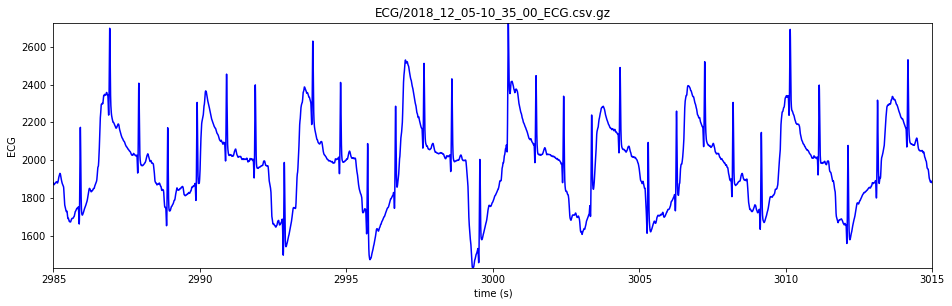

In [2]:
offset = 3000 # seconds
window = 30 # seconds

plt.clf() 
stress.plot_ecg(ecg, offset = offset, window = window)

plt.title(filename)
fig = plt.gcf()
fig.set_size_inches(15.75, 4.5)
plt.show()

The original Pan-Tompkins algorithm is

>  [1] Jiapu Pan, Willis J. Tompkins. "A real-time QRS detection algorithm."
>  IEEE Transactions onBiomedical Engineering 3 (1985): 230-236.    

There are many implementations. The filtering process is simple, but the devil is in the details: the adaptive thresholds, where each implementation makes different choices. For many data sets where the ECG is relatively clean, these choices don't seem to make much difference, but for our data many implementations produce quite poor results. We base our implementation off an [MIT licensed](https://opensource.org/licenses/MIT) (open source, no restrictions) python code from [github.com/pickus91/HRV](https://github.com/pickus91/HRV).

The original Pan-Tompkins QRS detector (including this python implementation) find very few beats and most of those are noise.
Initialization fails because the start of the recording is noisy
(lots of movement as the instrument is turned on, attached to the patient,
 and the patient moves into the virtual reality simulator).
Even with a good initialization, noise due to movement will often drive the Pan-Tompkins
thresholds into a region where it will never detect another QRS complex.

Note the option `decay = None`, disabling new code.

1611 QRS complexes found


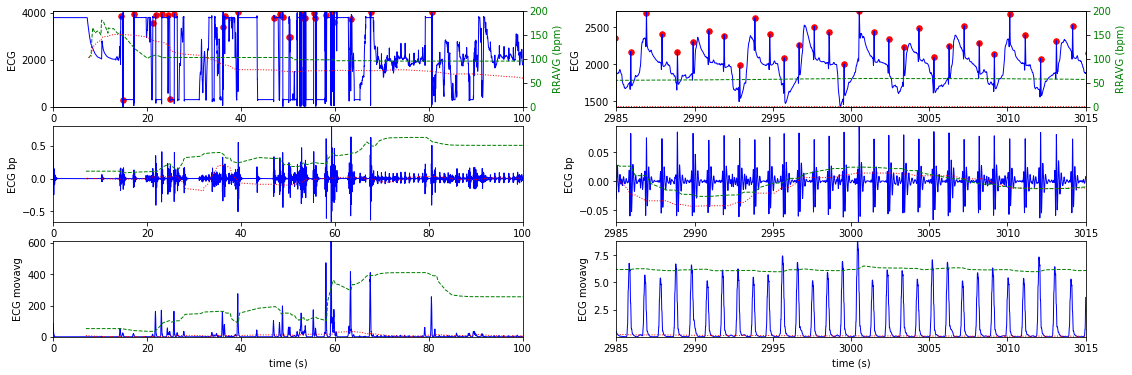

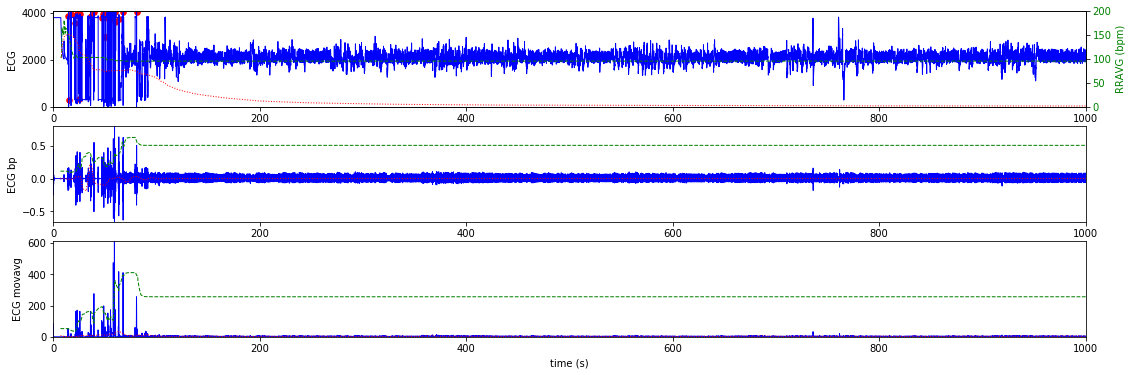

In [3]:
qrs, data = stress.pan_tompkins.pan_tompkins(ecg, fs, decay = None)
print('%d QRS complexes found'%(len(qrs)))

plt.clf()
ax = [ plt.subplot(321),
       plt.subplot(323),
       plt.subplot(325) ]
win = 100
stress.pan_tompkins.plot_pan_tompkins(data, ax = ax, window = win, offset = win/2)
ax = [ plt.subplot(322),
       plt.subplot(324),
       plt.subplot(326) ]
stress.pan_tompkins.plot_pan_tompkins(data, ax = ax, window = window, offset = offset)

fig = plt.gcf()
fig.set_size_inches(18.5, 6)
plt.show()

plt.figure()
ax = [ plt.subplot(311),
       plt.subplot(312),
       plt.subplot(313) ]
win = 1000
stress.pan_tompkins.plot_pan_tompkins(data, ax = ax, window = win, offset = win/2)

fig = plt.gcf()
fig.set_size_inches(18.5, 6)
plt.show()

By allowing the thresholds to decay after 10x the expected max R-R interval,
at a rate set by `decay` per detected signal peak,
we can now recover when these detection thresholds are either initialized
to a large value or are driven to a large value due to random noise (for example, movement artifacts).

Note the option `decay != None`.

We now detect many beats for most available ECG recordings and the R peaks are quite accurate, even for moderately noisy data.

1617 QRS complexes found


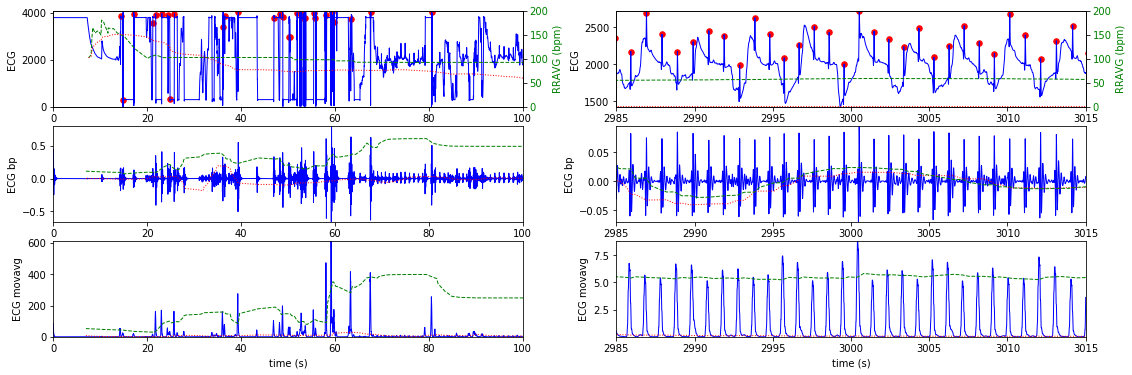

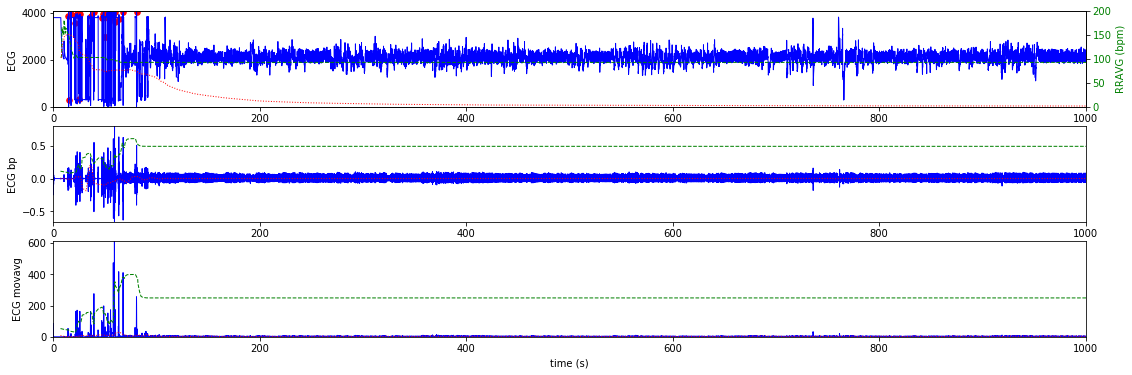

In [4]:
qrs, data = stress.pan_tompkins.pan_tompkins(ecg, fs, decay = 0.99)
print('%d QRS complexes found'%(len(qrs)))

plt.clf()
ax = [ plt.subplot(321),
       plt.subplot(323),
       plt.subplot(325) ]
win = 100
stress.pan_tompkins.plot_pan_tompkins(data, ax = ax, window = win, offset = win/2)
ax = [ plt.subplot(322),
       plt.subplot(324),
       plt.subplot(326) ]
stress.pan_tompkins.plot_pan_tompkins(data, ax = ax, window = window, offset = offset)

fig = plt.gcf()
fig.set_size_inches(18.5, 6)
plt.show()

plt.figure()
ax = [ plt.subplot(311),
       plt.subplot(312),
       plt.subplot(313) ]
win = 1000
stress.pan_tompkins.plot_pan_tompkins(data, ax = ax, window = win, offset = win/2)

fig = plt.gcf()
fig.set_size_inches(18.5, 6)
plt.show()

Using the R peaks detected by the modified Pan-Tompkins, we can calculate R-R intervals (heart rate, HR)
in beats per minute (bpm), and the heart rate variability (HRV) in beats per minute.

For HRV, there are many alternatives to Root Mean Square of Successive Differences (RMSSD). See [wikipedia/Heart_rate_variability](https://en.wikipedia.org/wiki/Heart_rate_variability) for some examples.

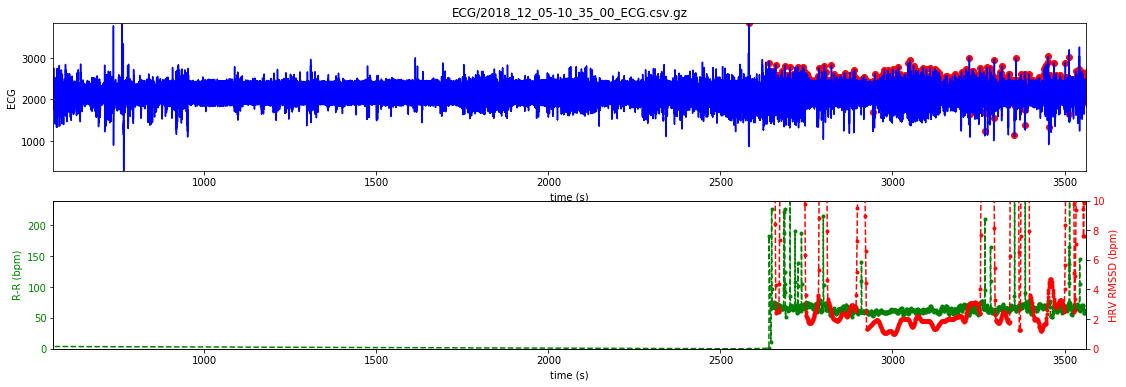

In [5]:
if True:
    offset_t = len(ecg)/fs/2;
    window_t = offset
else:
    offset_t = offset
    window_t = window *4

t_qrs, bpm = stress.calc_hr_bpm(qrs) # heart rate in beats per minute (bpm), and associated times for each change in bpm
hrv = stress.calc_hrv_bpm(bpm)  # heart rate variability in beats per minute

    
plt.clf()
ax = plt.subplot(211)
stress.plot_ecg(ecg, qrs, offset = offset_t, window = window_t)
plt.title(filename)

ax = plt.subplot(212)
stress.plot_hr_bpm(t_qrs, bpm, hrv, window = window_t, offset = offset_t)

fig = plt.gcf()
fig.set_size_inches(18.5, 6)
plt.show()

And plot signal quality index (SQI) from

>  [2] M. Abdelazez, P. Quesnel, A. D. C. Chan, H. Yang. Signal Quality Analysis of Ambulatory Electrocardiograms to Gate False Myocardial Ischemia Alarms.
> IEEE Transactions on Biomedical Engineering 64(6) 1318-1325, 2017. [10.1109/TBME.2016.2602283](https://doi.org/10.1109/TBME.2016.2602283)


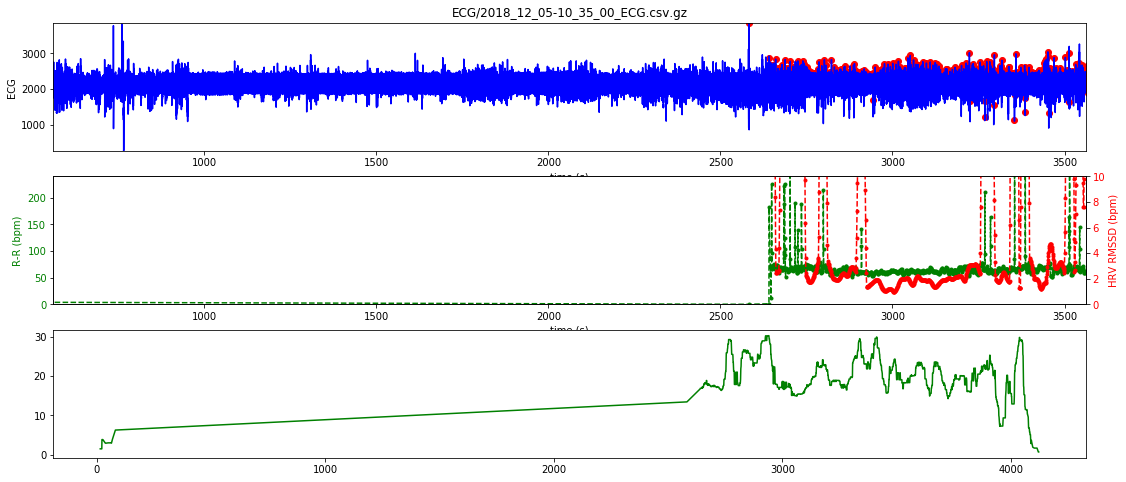

In [6]:
sqi = stress.calc_hr_sqi(ecg, qrs)

plt.clf() 
ax = plt.subplot(311)
stress.plot_ecg(ecg, qrs, offset = offset_t, window = window_t)
plt.title(filename)

ax = plt.subplot(312)
stress.plot_hr_bpm(t_qrs, bpm, hrv, window = window_t, offset = offset_t)

ax = plt.subplot(313)
stress.plot_hr_sqi(t_qrs, sqi, offset = offset_t, window = window_t)

fig = plt.gcf()
fig.set_size_inches(18.5, 8)
plt.show()